In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get all normal useragents data
def get_all_normaluseragents_df(count : int = 100):
    df_firefox = pd.read_csv("data_collection/firefox.csv")
    df_chrome = pd.read_csv("data_collection/chrome.csv")
    df_ie = pd.read_csv("data_collection/internet-explorer.csv")
    df_opera = pd.read_csv("data_collection/opera.csv")
    df_safari = pd.read_csv("data_collection/safari.csv")
    df_android = pd.read_csv("data_collection/android-browser.csv")

    df_firefox.drop(["version","commonality"],axis=1,inplace=True)
    df_chrome.drop(["version","commonality"],axis=1,inplace=True)
    df_ie.drop(["version","commonality"],axis=1,inplace=True)
    df_opera.drop(["version","commonality"],axis=1,inplace=True)
    df_safari.drop(["version","commonality"],axis=1,inplace=True)
    df_android.drop(["version","commonality"],axis=1,inplace=True)

    firefox_ua =  df_firefox.head(count)
    chrome_ua =  df_chrome.head(count)
    ie_ua =  df_ie.head(count)
    safari_ua =  df_safari.head(count)
    android_ua =  df_android.head(count)

    useragents = pd.concat([firefox_ua , chrome_ua , ie_ua , safari_ua , android_ua] , axis=0)
    shuffled_ua = useragents.sample(frac=1).reset_index(drop=True)
    shuffled_ua['is_badua'] = 0
    return shuffled_ua

In [2]:
def get_all_useragents_df():
    normal_ua = get_all_normaluseragents_df(200)
    bad_ua = pd.read_csv("bad_useragents.csv")
    df_useragents = pd.concat([normal_ua , bad_ua],axis=0)
    df_useragents = df_useragents.sample(frac=1).reset_index(drop=True)
    return df_useragents

In [3]:
#describing user agent data frame

pd.set_option('display.max_colwidth',80)
df_useragents = get_all_useragents_df()
df_useragents.groupby("is_badua").describe()

ua         \
         count unique   
is_badua                
0         1000   1000   
1          624    621   

                                                                                           \
                                                                                      top   
is_badua                                                                                    
0         Mozilla/5.0 (Linux; U; Android 2.3.6; en-us; SGH-T679 Build/GINGERBREAD) App...   
1                                                                                heritrix   

               
         freq  
is_badua       
0           1  
1           2

'wasalive-bot'

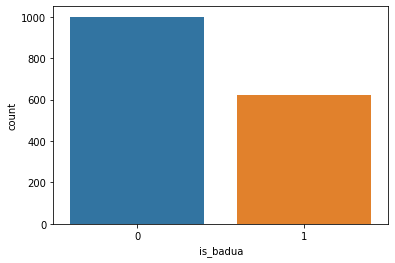

In [4]:
sns.countplot(x="is_badua" , data=df_useragents )
df_useragents['ua'][4]

In [5]:
import string
ua_punctuation = string.punctuation.replace(".","")

def process_ua(ua : str):
    temp = [c for c in ua if c not in ua_punctuation ]
    punc_removed_ua = "".join(temp).lower()
    punc_removed_ua.split()

    #removing stop words
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer

    pt = PorterStemmer()
    stopwords_removed_ua = [word for word in punc_removed_ua.split() if word not in stopwords.words('english')]  
    stemmed_ua = [pt.stem(word) for word in stopwords_removed_ua]
    return stemmed_ua


In [6]:
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer


cv = CountVectorizer(analyzer=process_ua)
dfm = cv.fit_transform(df_useragents['ua'])

tfid = TfidfVectorizer(analyzer=process_ua)
tfid_matrix = tfid.fit_transform(df_useragents['ua'])


# a = pd.DataFrame(tfid_matrix.toarray(),columns=tfid.get_feature_names_out())
# df_useragents['is_badua'][89]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

x_train , x_test , y_train , y_test = train_test_split(dfm ,df_useragents['is_badua'] , test_size=0.4 )

In [21]:
knc = KNeighborsClassifier(n_neighbors=100)
knc.fit(x_train,y_train)

y_pred = knc.predict(x_test)
print('KNeighbors Accuracy_score: ',accuracy_score(y_test,y_pred))
print('KNeighbors confusion_matrix: ', confusion_matrix(y_test, y_pred)) 

x_test

#save the model
from joblib import dump
dump(knc , filename="../blasterModels/user_agents_models/knc.joblib")

dfm_test = cv.transform(["Mozilla/5.0 (Linux; U; Android 2.3.6; en-us; SGH-T679 Build/GINGERBREAD) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1"])
knc.predict(dfm_test)
# df_useragents['ua'][3]

KNeighbors Accuracy_score:  0.9446153846153846
KNeighbors confusion_matrix:  [[360  36]
 [  0 254]]


array([0])

In [ ]:
mnb = MultinomialNB(alpha = 0.5)
mnb.fit(x_train,y_train)

y_mnb = mnb.predict(x_test)

print('Naive Bayes Accuracy: ', accuracy_score( y_test , y_mnb))
print('Naive Bayes confusion_matrix: ', confusion_matrix(y_test, y_mnb))

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
svc.fit(x_train,y_train)
y_svc = svc.predict(x_test)
print('SVM Accuracy: ', accuracy_score( y_test , y_svc))
print('SVM confusion_matrix: ', confusion_matrix(y_test, y_svc))

In [ ]:
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=252)
dtc.fit(x_train,y_train)
y_dtc = dtc.predict(x_test)
print('Decision Tree Accuracy: ',accuracy_score(y_test,y_dtc))
print('Decision Tree confusion_matrix: ', confusion_matrix(y_dtc, y_test))  

In [ ]:
rfc = RandomForestClassifier(n_estimators=37, random_state=252)
rfc.fit(x_train,y_train)
y_rfc = rfc.predict(x_test)

print('Random Forest Accuracy_score: ',accuracy_score(y_test,y_rfc))
print('Random Forest confusion_matrix: ', confusion_matrix(y_rfc, y_test)) 

In [ ]:
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_lr = lr.predict(x_test)

print('Logistic Regression Accuracy_score: ',accuracy_score(y_test,y_lr))
print('Logistic Regression confusion_matrix: ', confusion_matrix(y_test, y_lr)) 